https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0

https://towardsdatascience.com/running-jupyter-notebook-on-the-cloud-in-15-mins-azure-79b7797e4ef6

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import WikiText2
import pandas as pd
from nltk.corpus import brown
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import os
import random

In [264]:
# from torchtext.datasets import WikiText2
# from torchtext.datasets import IMDB
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# from torch.utils.data import dataset

# train_iter = WikiText2(split='train')
# tokenizer = get_tokenizer('basic_english')
# vocab1 = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
# vocab1.set_default_index(vocab['<unk>'])
from datasets import load_dataset
wikitext2 = load_dataset("wikitext", "wikitext-2-v1")


In [303]:
DATA_SPLIT = "train"
text = wikitext2[DATA_SPLIT]['text']
text = [item.lower().strip() for item in text if len(item) > 0]
len(text)

23767

In [304]:
text = [item.split(" ") + ["\n"] for item in text if "=" not in item]

In [305]:
# Prepare Corpus
DATA_LIMIT = None #paragraph limit
all_words = []
for paragraph in text[:DATA_LIMIT]:
    all_words += paragraph
all_words = pd.Series(all_words)
len(all_words)

2023109

In [306]:
len(all_words.unique())

28909

In [307]:
#filter out rare words
N_times = 100
v_counts = all_words.value_counts()
corpus = pd.Series([key for key in v_counts.keys() if v_counts[key] >= N_times])
corpus

0             the
1               ,
2               .
3              of
4           <unk>
          ...    
2151    southwest
2152         1965
2153        items
2154         join
2155          nba
Length: 2156, dtype: object

In [308]:
def tensor_to_array(t):
    return np.array([i.item() for i in list(t)])

### Old NLTK Dataset

In [182]:
# brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
# print(len(pd.Series(brown_news_tagged).unique()))
# len(brown.words())

In [183]:
# Prepare Corpus
# DATA_LIMIT = 25000

# remove_punc = [word for word in brown_news_tagged]
# text = pd.Series([word[0].lower() for word in remove_punc][:DATA_LIMIT])
# len(text)

In [184]:
# #filter out rare words
# N_times = 25
# v_counts = text.value_counts()
# corpus = pd.Series([key for key in v_counts.keys() if v_counts[key] >= N_times])
# len(corpus)


### Continuing

In [272]:
vocab = {}
for i in range(len(corpus)):
    vocab[corpus[i]] = i
len(vocab)

2156

In [309]:
version = "april28_WT2_nodatalim_20epoch_64dim_100minf_2window"
torch.save(vocab, f"saves/vocab_{version}.pt")

In [286]:
enc_text = [[vocab[word] if word in vocab else vocab["<unk>"] for word in paragraph] for paragraph in text]
len(enc_text)

2176

In [287]:
SCANNING_WINDOW = 2
#maybe need to split into paragraphs b/c different topics...
#returns context, middle word
def get_data(index, window, data):
    return list(data[index-window:index])+list(data[index+1:index+window+1]), data[index]

In [288]:
x = []
y = []
count = 0
for paragraph in enc_text:
    if count % (len(enc_text)//16) == 0:
        print("•", end="")
    for i in range(SCANNING_WINDOW, len(paragraph) - SCANNING_WINDOW):
        if paragraph[i] == vocab["<unk>"]:
            continue
        a, b = get_data(i, SCANNING_WINDOW, paragraph)
        x.append(a)
        y.append(b)
    count+=1
    
torch.save(x, f"train_data/{DATA_SPLIT}_data_x_wt2_window2_100minf.pt")
torch.save(y, f"train_data/{DATA_SPLIT}_data_y_wt2_window2_100minf.pt")

••••••••••••••••

In [302]:
error

SyntaxError: 'break' outside loop (668683560.py, line 1)

Start here for training...

In [289]:
folder = "train_data/"
version1 = "_data_"
version2 = "_wt2_window4_100minf.pt"

In [290]:
x_test = torch.load(f"{folder}test{version1}x{version2}")

In [291]:
y_test = torch.load(f"{folder}test{version1}y{version2}")

In [292]:
x_train = torch.load(f"{folder}train{version1}x{version2}")
len(x_train) + len(x_test)

1628009

In [293]:
y_train = torch.load(f"{folder}train{version1}y{version2}")
len(y_train) + len(y_test)

1628009

In [214]:
vocab = torch.load(f"saves/vocab_{version}.pt")
len(vocab)

4078

In [294]:
from net import Net_CBOW

In [295]:
EMBED_DIMENSION = 128
net = Net_CBOW(len(vocab), EMBED_DIMENSION)

net.zero_grad()
criterion = nn.CrossEntropyLoss()
losses = []

In [296]:
NUM_EPOCHS = 20

optimizer = optim.Adam(net.parameters(), lr=0.025)
scheduler = optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, total_iters=NUM_EPOCHS)

In [310]:
print("RUN       " + ("•••••••••|"*10))
indices = list(range(len(x_train)))
for epoch in range(NUM_EPOCHS):
    print("RUN", str(epoch+1)+"/"+str(NUM_EPOCHS), end=": ")
    for i in range(len(x_train)):
        if i % (len(x_train)//100) == 0:
            print("•", end="")
        index = indices[i]
        context, target = x_train[index], y_train[index]
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(torch.tensor(context))
        loss = criterion(output, torch.tensor(target))
        loss.backward()
        optimizer.step()    # Does the update

    for context, target in zip(x_test, y_test):
        output = net(torch.tensor(context))
        losses.append(criterion(output, torch.tensor(target)).item())
    print(scheduler.get_last_lr())

    scheduler.step()
    print()
    random.shuffle(indices)
    torch.save(net, f"saves/apr27epochs/model_{version}_epoch{str(epoch)}.pt")

RUN       •••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|
RUN 1/20: •46
21
777
46
1
2
3
0
90
20
1
1822
1011
7
14
908
626
961
1
22
8
304
12
582
249
70
449
19
5
17
0
1765
2
157
6
253
360
6
961
1
23
22
0
238
70
6
0
96
2
0
158
3
5
723
12
62
14
42
1
0
335
1080
7
0
38
70
5
1674
0
9
9
1
8
316
1060
2059
0
1702
3
59
0
103
117
54
1916
1650
290
608
5
33
122
0
1060
9
6
299
1
68
8
185
1709
3
0
142
1164
13
317
2
69
23
0
1155
578
3
0
96
1
23
43
1821
1
92
14
407
0
70
65
17
96
2
281
5
99
427
24
475
1
162
18
317
531
2
8
185
161
3
1123
0
1602
2
0
70
16
660
1083
10
19
1460
6
961
1
5
10
728
19
99
777
5
416
516
2
45
365
1
23
203
1849
1
162
18
29
2118
1346
6
268
3
15
87
2
23
10
43
64
5
29
266
249
96
2
193
7
477
1460
3
317
1
908
10
39
1
36
8
18
0
70
16
2118
1346
10
157
6
682
2
66
566
7
0
18
0
421
3
46
1895
17
0
196
1
908
22
8
304
12
582
70
94
456
345
398
3
8
316
1060
5
345
115
6
122
1786
338
2
788
33
830
111
2024
245
12
141
18
281
1
18
515
111
5
111
2124
2


KeyboardInterrupt: 

In [298]:
torch.save(net, f"saves/model_{version}.pt")
# torch.save(vocab, f"saves/vocab_{version}.pt")

#Note that 4/26 20epoch version got to a loss of 10

In [299]:
loss_per_epoch = []
for i in range(NUM_EPOCHS):
    loss_per_epoch += [sum(losses[(i)*len(x_test):(i+1)*len(x_test)])/len(x_test)]

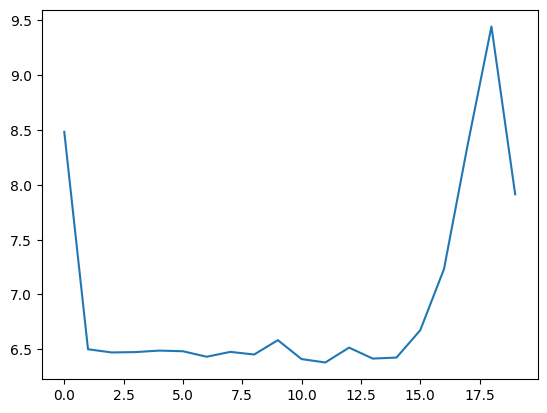

In [300]:
plt.plot(loss_per_epoch)
plt.show()

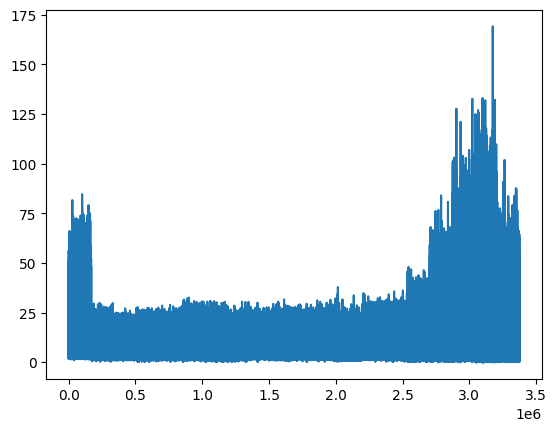

In [301]:
plt.plot(losses)
plt.show()

In [252]:
# get first layer of the model
embeddings = list(net.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalize the embeddings layer
norms = (embeddings ** 2).sum(axis=1) ** (0.5)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

(4078, 64)

In [255]:
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_tsne = tsne.fit_transform(embeddings_df)
embeddings_df_tsne = pd.DataFrame(embeddings_df_tsne)

embeddings_df_tsne.index = vocab.keys()

In [257]:
numeric = embeddings_df_tsne.index.str.isnumeric()
color = np.where(numeric, "green", "gray")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_tsne[0],
        y=embeddings_df_tsne[1],
        mode="text",
        text=embeddings_df_tsne.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("word2vec_visualization.html")
fig

In [311]:
def lookup_id(word, vocab=vocab):
    if word not in vocab:
        return vocab["<unk>"]
    return vocab[word]

In [312]:
def lookup_token(word_id, vocab=vocab):
    for word in vocab:
        if vocab[word] == word_id:
            return word
    return None

In [313]:
def get_top_similar(word: str, topN: int = 10):
    if word not in vocab:
        print("Out of vocabulary word")
        return
    word_id = lookup_id(word)

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        # sim_word = vocab.lookup_token(sim_word_id)
        sim_word = "<unk_>"
        for k in vocab:
            if vocab[k] == sim_word_id:
                sim_word = k
                break
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [317]:
for word, sim in get_top_similar("1").items():
    print("{}: {:.3f}".format(word, sim))

radio: 0.473
<unk_>: 0.348
27: 0.359
1950s: 0.347
@,@: 0.342
pair: 0.341


In [318]:
emb1 = embeddings[vocab["father"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["female"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(lookup_token(word_id), dists[word_id]))

father: 0.694
None: 0.592
covered: 0.591
None: 0.534
female: 0.533
